In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(8, 64)
        self.dense2 = nn.Linear(64, 32)
        self.dense3 = nn.Linear(32, 4)

        nn.init.zeros_(self.dense1.bias)
        nn.init.zeros_(self.dense2.bias)
        nn.init.zeros_(self.dense3.bias)
        
        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense2.weight, nonlinearity='relu')
        with torch.no_grad():
            self.dense3.weight *= 0.1

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.softmax(self.dense3(x), dim=1)
        return x

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

EPISODES = 10000

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='rgb_array')

policy = Model()
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

discount = 0.99
losses = []
rewards = []
max_reward = 0

for e in range(EPISODES):
    observation, info = env.reset()

    log_probs = []
    episode_rewards = []
    total_episode_reward = 0

    episode_over = False
    while not episode_over:

        state = torch.from_numpy(observation).view(1, -1)

        # action = env.action_space.sample()  # agent policy that uses the observation and info
        probs = policy(state)
        action = torch.multinomial(probs, num_samples=1).item()
        observation, reward, terminated, truncated, info = env.step(action)

        log_probs.append(torch.log(probs[0, action]))
        episode_rewards.append(reward)
        total_episode_reward += reward

        episode_over = terminated or truncated
    
    rewards.append(total_episode_reward)
    if total_episode_reward > max_reward:
        max_reward = total_episode_reward
        print(f"New max of {max_reward} in episode {e + 1}")

    returns = []
    R = 0
    for r in reversed(episode_rewards):
        R = r + discount * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    loss = 0
    optimizer.zero_grad()
    for log_prob, R in zip(log_probs, returns):
        loss += -log_prob * R
        
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    losses.append(loss.item())

    if (e + 1) % 500 == 0:
        print(f"Episodes {(e - 499, e)}: Avg Loss- {sum(losses[e-499:e+1])/500}, Avg Return- {sum(rewards[e-499:e+1])/500}")
        
env.close()

/Users/varun/Documents/venvs/3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


New max of 52.26491911771518 in episode 18
New max of 94.53030919776376 in episode 381


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10685b560>>
Traceback (most recent call last):
  File "/Users/varun/Documents/venvs/3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


New max of 113.19592287542697 in episode 429


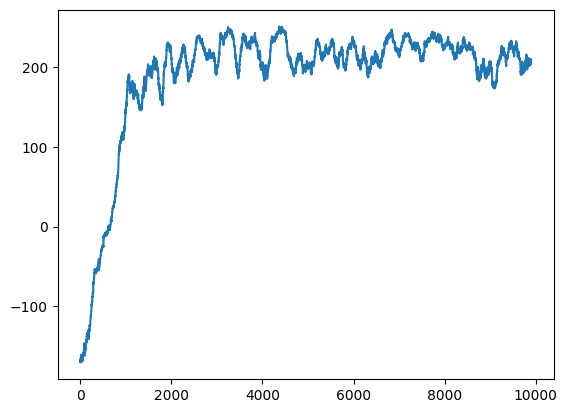

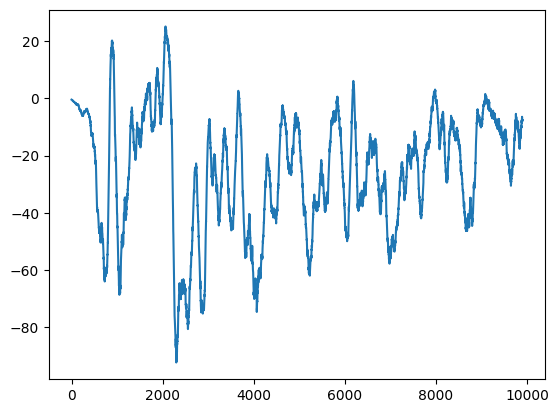

In [15]:
import numpy as np

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, 100))
plt.figure()
plt.plot(moving_average(losses, 100))

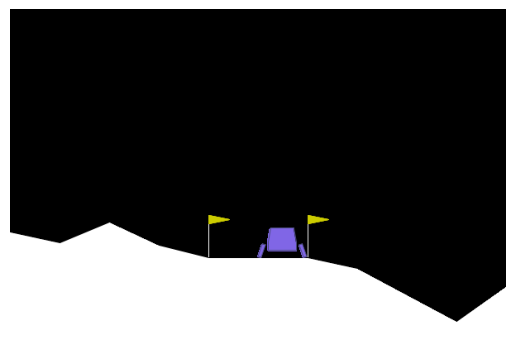

Final Return: 287.9860935561514
Average Return over 500 episodes: 210.25941983921913


In [10]:
show = True
rewards = []

for _ in range(500):
    observation, info = env.reset()
    episode_reward = 0
    episode_over = False
    while not episode_over:
        if show:
            frame = env.render()
            clear_output(wait=True)
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
            time.sleep(0.002)

        with torch.no_grad():
            probs = policy(torch.from_numpy(observation).view(1, -1))
            action = torch.argmax(probs, dim=1).item()

        observation, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward

        episode_over = terminated or truncated

    if show:
        show = False
        print(f"Final Return: {episode_reward}")

    rewards.append(episode_reward)

print(f"Average Return over 500 episodes: {sum(rewards) / 500}")

env.close()

In [11]:
torch.save(policy.state_dict(), f"models/lunar_lander/REINFORCE_210")